# Imports

In [1]:
import sys
import warnings
import inflection
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt

from pandas.plotting         import scatter_matrix
from IPython.display         import Image
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import MinMaxScaler
from sklearn.preprocessing   import OneHotEncoder
from sklearn.compose         import make_column_transformer
from sklearn.pipeline        import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.cluster         import KMeans
from sklearn.calibration     import calibration_curve
from sklearn.naive_bayes     import CategoricalNB
from sklearn.naive_bayes     import GaussianNB
from xgboost                 import XGBClassifier

np.random.seed(123)
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=3)
pd.options.display.max_rows = 20
pd.options.display.max_columns = 30
#warnings.filterwarnings('ignore')

# Intro: Loading Data - Helper Functions

## Perguntas:

1. Qual a taxa de Churn atual da empresa?
2. Qual a Performance do modelo em classificar os clientes como churns?
4. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
5. Para quais clientes você daria um incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento)?  
Lembrando que a soma dos incentivos para cada cliente não pode ultrapassar os  R$10,000.

## Dataset Description

**RowNumber**: corresponds to the record (row) number and has no effect on the output.  
**CustomerId**: contains random values and has no effect on customer leaving the bank.  
**Surname**: the surname of a customer has no impact on their decision to leave the bank.  
**CreditScore**: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.  
**Geography**: a customer’s location can affect their decision to leave the bank.  
**Gender**: it’s interesting to explore whether gender plays a role in a customer leaving the bank.  
**Age**: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.  
**Tenure**: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.  
**Balance**: also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.  
**NumOfProducts**: refers to the number of products that a customer has purchased through the bank.  
**HasCrCard**: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.  
**IsActiveMember**: active customers are less likely to leave the bank.  
**EstimatedSalary**: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.  
**Exited**: whether or not the customer left the bank. (0=No,1=Yes)

##  Helper Functions

### Data Handling:

In [2]:
def get_data(infile='data/churn.csv'):
    return pd.read_csv(infile)

def rename_cols(df):
    snake_case = lambda x: inflection.underscore(x)
    df.columns = list(map(snake_case, df.columns))
    rename_dict = {'num_of_products': 'num_products',
                   'has_cr_card': 'credit_card',
                   'is_active_member': 'active_member',
                   'estimated_salary': 'salary'}
    df.rename(columns=rename_dict, inplace=True)
    return df

def feature_eng(df, cols_drop=['row_number', 'customer_id', 'surname']):
    df.drop(columns=cols_drop, inplace=True) 
    # create new cols here
    return df

def reload_data():
    df = get_data()
    df = rename_cols(df)
    return feature_eng(df)

### Tools for Plotting:

In [3]:
def hargs(bins=np.arange(0, 2, 1), hstep='step', lwidth=3, c='r', label='Churn', normed=False):
    return {'bins': bins, 'histtype': hstep, 'linewidth': lwidth, 'color': c, 'density': normed, 'label': label}

In [4]:
def plot_hist(ax, df, col, bins, normed=False, loc='best', mask=':'):    
    ax.hist(df[mask][col], **hargs(bins=bins, normed=normed))
    ax.hist(df[~mask][col], **hargs(bins=bins, normed=normed, c='b', label='not Churn'))
    ax.set_xlabel(col)
    ax.legend(loc=loc)
    
def plot_by_country(ax1, ax2, df, var, bins):
    mask = (df.exited == 1)
    normed = False
    ax1.hist(df.loc[(df.geography == 'Germany'), var], **hargs(bins=bins, normed=normed, c='k', label='GER'))       
    ax1.hist(df.loc[(df.geography == 'Spain'), var], **hargs(bins=bins, normed=normed, c='r', label='SPA'))
    ax1.hist(df.loc[(df.geography == 'France'), var], **hargs(bins=bins, normed=normed, c='b', label='FRA'))
    ax1.set_xlabel(var)
    if var == 'credit_score':
        ax1.legend(loc='upper left')

    normed = True
    ax2.hist(df.loc[(df.geography == 'Germany') & mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER Churn'))       
    ax2.hist(df.loc[(df.geography == 'Germany') & ~mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER not Churn'), linestyle='dashed')
    ax2.hist(df.loc[(df.geography == 'Spain') & mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA Churn'))       
    ax2.hist(df.loc[(df.geography == 'Spain') & ~mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA not Churn'), linestyle='dashed')
    ax2.hist(df.loc[(df.geography == 'France') & mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA Churn'))       
    ax2.hist(df.loc[(df.geography == 'France') & ~mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA not Churn'), linestyle='dashed')    
    ax2.set_xlabel(var)
    if var == 'credit_score':
        ax2.legend(loc='upper left')
        
def plot_ratios(ax1, ax2, df, var, bins):
    ratios = []
    normed = False
    c1, b, _ = ax1.hist(df.loc[(df.geography == 'Germany') & mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER Churn'))       
    c2, b, _ = ax1.hist(df.loc[(df.geography == 'Germany') & ~mask, var], **hargs(bins=bins, normed=normed, c='k', label='GER not Churn'), linestyle='dashed')
    ratios.append(c1/c2)
    c1, b, _ = ax1.hist(df.loc[(df.geography == 'Spain') & mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA Churn'))       
    c2, b, _ = ax1.hist(df.loc[(df.geography == 'Spain') & ~mask, var], **hargs(bins=bins, normed=normed, c='r', label='SPA not Churn'), linestyle='dashed')
    ratios.append(c1/c2)
    c1, b, _ = ax1.hist(df.loc[(df.geography == 'France') & mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA Churn'))       
    c2, b, _ = ax1.hist(df.loc[(df.geography == 'France') & ~mask, var], **hargs(bins=bins, normed=normed, c='b', label='FRA not Churn'), linestyle='dashed')    
    ratios.append(c1/c2)
    ax1.set_xlabel(var)
    if var == 'credit_score':
        ax1.legend(loc='upper left')
    
    colors = ['black', 'red', 'blue']
    for ratio, c in zip(ratios, colors):
        ax2.bar(x=np.arange(0, len(ratio), 1), height=ratio, width=1, align='edge', fill=False, edgecolor=c, linewidth=2)
    ax2.set_xticks(np.arange(0, len(ratio) + 1, 1))
    ax2.set_xticklabels(bins, rotation=45)
    ax2.set_xlabel(var)

In [5]:
def draw_grid(ax, ymax=.5):
    ticks = np.arange(0., ymax, .1)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ticks = np.arange(.05, ymax-.05, .1)
    ax.set_yticks(ticks=ticks, minor=True)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=True)
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.15)
    ax.grid(True, which='minor', axis='y', color='gray', linestyle='-', alpha=.05)
    
def draw_rate(ax, df, col):
    table = df.groupby(col).exited.mean().reset_index()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    if col == 'gender':
        ax.set_xticklabels(['Male', 'Female'])
    color = ['red', 'blue'] 
    if len(table) > 2:
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(['France', 'Spain', 'Germany'])
        color = ['blue', 'red', 'yellow']
    ax.bar(x=table[col], height=table.exited, width=[0.5]*len(table), color=color)
    ax.set_title(f'Churn Rate by {col}')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Churn Rate')
    
def draw_rate_country(ax, df, col):
    country = 'Germany'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col]-0.1, height=table.exited, width=[0.1, 0.1], color=['yellow', 'yellow'], label=country)
    
    country = 'Spain'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col], height=table.exited, width=[0.1, 0.1], color=['red', 'red'], label=country)

    country = 'France'
    table = df[df['geography'] == country].groupby(col).exited.mean().reset_index()
    ax.bar(x=table[col]+0.1, height=table.exited, width=[0.1, 0.1], color=['blue', 'blue'], label=country) 

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_title(f'Churn Rate by {col} and Country')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Churn Rate')
    
    ax.legend(loc='upper center')

### Statistics of Pivot Tables:

In [6]:
def print_prop(table):
    name = table.columns.name
    a0, b0 = table[0]
    a1, b1 = table[1]
    tot0, tot1 = a0 + b0, a1 + b1
    tot = tot0 + tot1
    print(f'Total of {name} = {tot}')
    print(f'Proportion of {name}==0: {100.*tot0/tot:.2f}%')
    print(f'Proportion of {name}==1: {100.*tot1/tot:.2f}%')
    print(f'Proportion of {name}==0 that Churned: {100.*b0/tot0:.2f}%')
    print(f'Proportion of {name}==1 that Churned: {100.*b1/tot1:.2f}%')
    
def print_prop3(table):
    name = table.columns.name
    a0, b0 = table['France']
    a1, b1 = table['Spain']
    a2, b2 = table['Germany']
    tot0, tot1, tot2 = a0 + b0, a1 + b1, a2 + b2
    tot = tot0 + tot1 + tot2
    print(f'Total of {name} = {tot}')
    print(f'Proportion of France: {100.*tot0/tot:.2f}%')
    print(f'Proportion of Spain: {100.*tot1/tot:.2f}%')
    print(f'Proportion of Germany: {100.*tot2/tot:.2f}%')
    print(f'Proportion of France that Churned: {100.*b0/tot0:.2f}%')
    print(f'Proportion of Spain that Churned: {100.*b1/tot1:.2f}%')
    print(f'Proportion of Germany that Churned: {100.*b2/tot2:.2f}%')

### Lift Curve

In [7]:
def get_lift_gain(y, y_pred, step=0.1, model='Model', plot=False):
    aux_lift = pd.DataFrame()
    aux_lift['true'] = y
    aux_lift['pred'] = y_pred
    aux_lift.sort_values('pred', ascending=False, inplace=True)

    x_val = np.arange(step, step + 1, step)
    num_ones = aux_lift['true'].sum()
    N = len(aux_lift)
    ratio_ones = num_ones / N

    lifts = []
    gains = [0]
    for x in x_val:
        num_data = int(np.ceil(x * N)) 
        data_here = aux_lift.iloc[:num_data, :]
        num_ones_here = data_here['true'].sum()
        ratio_ones_here = num_ones_here / num_data
        gains.append(num_ones_here / num_ones)
        lifts.append(ratio_ones_here / ratio_ones)
           
    if plot:
        plot_lift(step, [lifts], [model])
    return lifts, gains

def get_rate(y, y_pred, step=0.1):
    aux_lift = pd.DataFrame()
    aux_lift['true'] = y
    aux_lift['pred'] = y_pred
    aux_lift.sort_values('pred', ascending=True, inplace=True)

    x_val = np.arange(0, 1, step)
    y_val = []
    for x in x_val:
        xlow = int(np.ceil(x * len(aux_lift))) 
        xhigh = int(np.ceil((x+step) * len(aux_lift))) 
        data_here = aux_lift.iloc[xlow:xhigh, :]
        ratio_ones_here = data_here['true'].sum() / len(data_here)
        y_val.append(ratio_ones_here)

    return y_val

In [95]:
colors = ['red', 'blue', 'black', 'green', 'purple', 'yellow']
def plot_lift(ax, ys, models, step):
    x = np.arange(step, step + 1, step)

    ax.plot(x, np.ones(len(x)), 'k--', label='Baseline')
    for y, model, color in zip(ys, models, colors):
        ax.plot(x, y, '-', color=color, linewidth=3, markersize=5, label=model)
    ax.set_xlabel('Proportion of Sample')
    ax.set_ylabel('Lift')
    ax.set_title('Lift Curve')
    ticks = np.arange(0, 1.1, .1)
    ax.set_xticks(ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.legend(loc='best')
        
    ticks = np.arange(0.1, 1.1, .1)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0.1, 1.)
    ymax = np.ceil(max(max(ys)))
    ticks = np.arange(0, ymax + 1, 1)
    ax.set_yticks(ticks=ticks, minor=False)
    ticks = np.arange(0.5, ymax, .5)
    ax.set_yticks(ticks=ticks, minor=True)
    ax.set_ylim(0, ymax + .5)
    
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='minor', axis='y', color='gray', linestyle='-', alpha=.1)
    
    return ax
    
def plot_rates(ax, ys, models, step):
    x = np.arange(0, 1+step, step)
    ax.plot(x, churn_ratio*np.ones(len(x)), 'k--', label='Baseline')
    for y, model, color in zip(ys, models, colors):
        ax.bar(x[:-1], y, width=step, align='edge', edgecolor=color, fill=False, label=model, linewidth=2)
    ax.set_xticks(x)
    ax.set_xlabel('Predicted Probability of Churn')
    ax.set_ylabel('Churn Rate')
    ax.legend(loc='best')    

    ticks = np.arange(0., 1.2, .2)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_ylim(0, 1.02)
    
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    
    return ax

def plot_cum_gain(ax, gains, models, step=0.1):
    ax.plot([0, churn_ratio, 1], [0, 1, 1], 'r--', linewidth=2, label='Ideal Classifier')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

    for gain, model, color in zip(gains, models, colors):
        ax.plot(np.arange(0, 1. + step, step), gain, linewidth=2, color=color, label=model)

    ax.set_title(f'Cumulative Gains')
    ax.set_xlabel(f'Percentage of Sample')
    ax.set_ylabel('Gain')
    ax.legend(loc='lower right')

    ticks = np.arange(0., 1.2, .2)
    ax.set_xticks(ticks=ticks, minor=False)
    ax.set_xticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_xlim(0, 1.)
    ax.set_yticks(ticks=ticks, minor=False)
    ax.set_yticklabels([f'{int(100*i)}%' for i in ticks], minor=False)
    ax.set_ylim(0, 1.02)
    
    ax.grid(True, which='major', axis='y', color='gray', linestyle='-', alpha=.5)
    ax.grid(True, which='major', axis='x', color='gray', linestyle='-', alpha=.5)

    return ax

## ROI Class

In [589]:
def knapsack(W, wt, val):
    n = len(val)
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    max_val = K[n][W]
    keep = [False] * n
    res = max_val
    w = W
    for i in range(n, 0, -1):
        if res <= 0: break
        if res == K[i - 1][w]: continue
        else:
            keep[i - 1] = True
            res = res - val[i - 1]
            w = w - wt[i - 1]
    del K
    return max_val, keep

In [616]:
class ROI():
    def __init__(self, df, ytrue, ypred, threshold=0.8, name='XGBoost'):
        self.df = df.copy()
        self.df['true'] = ytrue
        self.df['pred'] = ypred
        self.df.sort_values('pred', ascending=False, inplace=True)
        self.threshold_ = threshold
        self.name_ = name
        self.cards_ = [20_000, 200, 100, 50]

    def make_LTV(self):
        self.mean_sal = self.df.salary.mean()
        self.df['LTV'] = round(self.df.salary.apply(lambda x: 0.15*x if x < self.mean_sal else 0.2*x), 2)

    def make_churn(self):
        self.df['churn'] = self.df.pred.apply(lambda x: 1 if x >= self.threshold_ else 0)
            
    def get_profit(self):
        profit = 0
        modelchurn = 0
        for i in range(self.ncards_):
            entry = self.df.iloc[i]
            if entry.churn and entry.true:
                profit += entry.LTV
                modelchurn += 1
        self.profit_ = profit
        self.model_churn_ = 100.*modelchurn / self.ncards_
            
    def get_random(self):
        randomdf = self.df.sample(self.ncards_)
        profit = 0
        randomchurn = 0
        for i in range(self.ncards_):
            entry = randomdf.iloc[i]
            if entry.true:
                profit += entry.LTV
                randomchurn += 1
        self.random_churn_ = 100.*randomchurn / self.ncards_
        self.random_profit_ = profit
        
    def greedy_knapsack(self):
        churndf = self.df.loc[self.df.churn == 1, :]
        churndf.sort_values('LTV', ascending=False, inplace=True)        
        greedy = 0
        greedychurn = 0
        i = 0
        while i < self.ncards_:
            entry = churndf.iloc[i]
            if entry.true:
                greedy += entry.LTV
                greedychurn += 1
            i += 1
        print(i)
        self.greedy_ = greedy
        self.greedy_churn_ = 100.*greedychurn / self.ncards_
        
    def make_gift(self):
        gifts = []
        n = len(self.df)
        for i in range(n):
            entry = self.df.iloc[i]
            if entry.pred >= .99:
                gifts.append(self.cards_[0])
            elif entry.pred >= .95 and entry.pred < .99:
                gifts.append(self.cards_[1])
            elif entry.pred >= .90 and entry.pred < .95:
                gifts.append(self.cards_[2])
            else:
                gifts.append(self.cards_[3])
        self.df['gift'] = gifts
        
    def give_gift(self):
        self.make_gift()
        givedf = self.df[self.df.churn == 1]
        W = int(self.investment_ / self.cards_[-1])
        vals = givedf.LTV.astype(int).values
        wt = (givedf.gift / self.cards_[-1]).astype(int).values
        max_val, keep = knapsack(W, wt, vals)
        self.givedf = givedf[keep]
        profit = 0
        modelchurn = 0
        n = len(self.givedf)
        for i in range(n):
            entry = self.givedf.iloc[i]
            if entry.true:
                profit += (entry.LTV - entry.gift)
                modelchurn += 1
            else:
                profit += (0 - entry.gift)
        self.real_profit_ = profit
        self.real_churn_ = 100. * modelchurn / n

    def get_ROI(self):
        self.make_LTV()
        self.make_churn()
        self.get_profit()
        self.ROI_ = self.profit_ - self.investment_
        self.ROIpct_ = 100.*self.ROI_ / self.investment_
        self.get_random()
        self.greedy_knapsack()
        self.give_gift()
        
    def print_performance(self, investment=10_000, gift=100):
        self.investment_ = investment
        self.gift_ = gift
        self.ncards_ = int(investment / gift)
        self.get_ROI()
        print(f'Performance of {self.name_} - selecting the {self.ncards_} clients with highest churn probability:')
        print(f'ROI = ${self.ROI_:,.2f}')
        print(f'Percentage of {self.ncards_} clientes that were correctly identified as churning clients: {self.model_churn_:.1f}%')

        print(f'\nPerformance of selecting the {self.ncards_} richest clients (with Pchurn > {self.threshold_}):')
        print(f'ROI = ${self.greedy_ - self.investment_:,.2f}')
        print(f'Percentage of {self.ncards_} clientes that were correctly identified as churning clients: {self.greedy_churn_:.1f}%')
                
        print(f'\nPerformance of randomly selecting {self.ncards_} clients:')
        print(f'ROI = ${self.random_profit_ - self.investment_:,.2f}')
        print(f'Percentage of {self.ncards_} clientes that were correctly identified as churning clients: {self.random_churn_:.1f}%')
        
        print(f'\nPerformance of realisticaly selecting clients:')
        print(f'ROI = ${self.real_profit_:,.2f}')
        print(f'Percentage of {len(self.givedf)} clientes that were correctly identified as churning clients: {self.real_churn_:.1f}%')
        print(f'Total invested: {self.givedf.gift.sum()}')

##  Loading the Data

In [97]:
df1 = pd.read_csv('data/churn.csv')
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Descriptive Analysis

In [113]:
df2 = df1.copy()

## Rename Columns

In [114]:
df2.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [115]:
df2 = rename_cols(df2)
df2.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_products', 'credit_card',
       'active_member', 'salary', 'exited'],
      dtype='object')

In [116]:
df2.sample(3).T

,407,8961,5968
row_number,408,8962,5969
customer_id,15745354,15676117,15603743
surname,Franklin,Zinachukwudi,Tai
credit_score,611,603,526
geography,Spain,France,France
gender,Female,Male,Male
age,37,44,28
tenure,4,9,1
balance,0,0,112070
num_products,2,1,1


## Data Dimensions

In [117]:
nrows, ncols = df2.shape
print(f' Number of rows: {nrows}')
print(f' Number of columns: {ncols}')

 Number of rows: 10000
 Number of columns: 14


## Data Types

In [118]:
#df1.dtypes
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_number     10000 non-null  int64  
 1   customer_id    10000 non-null  int64  
 2   surname        10000 non-null  object 
 3   credit_score   10000 non-null  int64  
 4   geography      10000 non-null  object 
 5   gender         10000 non-null  object 
 6   age            10000 non-null  int64  
 7   tenure         10000 non-null  int64  
 8   balance        10000 non-null  float64
 9   num_products   10000 non-null  int64  
 10  credit_card    10000 non-null  int64  
 11  active_member  10000 non-null  int64  
 12  salary         10000 non-null  float64
 13  exited         10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Missing Data

In [119]:
df2.isna().sum()

row_number       0
customer_id      0
surname          0
credit_score     0
geography        0
gender           0
age              0
tenure           0
balance          0
num_products     0
credit_card      0
active_member    0
salary           0
exited           0
dtype: int64

## Fill Missing Data

No need for this in this project.  
(first time ever =p)

## Change Types

In [120]:
print(df2.gender.unique())
df2.gender = df2.gender.map({'Male': 0,'Female': 1})
df2.gender.head()

['Female' 'Male']


0    1
1    1
2    1
3    1
4    1
Name: gender, dtype: int64

In [121]:
print(df2.geography.unique())
df2['country'] = df2.geography.map({'France': 0, 'Spain': 1, 'Germany': 2})
df2.sample(3)

['France' 'Spain' 'Germany']


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
3711,3712,15729489,Hyde,762,Germany,1,34,8,98592.88,1,0,1,191790.29,1,2
3062,3063,15697574,Stewart,582,France,1,40,9,0.00,3,1,1,60954.45,0,0
7249,7250,15745804,Law,628,France,0,25,7,0.00,2,1,1,195977.75,0,0


## Descriptive Statistics

### Check Data, Drop Columns and Create Num/Cat Attributes

In [122]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_number     10000 non-null  int64  
 1   customer_id    10000 non-null  int64  
 2   surname        10000 non-null  object 
 3   credit_score   10000 non-null  int64  
 4   geography      10000 non-null  object 
 5   gender         10000 non-null  int64  
 6   age            10000 non-null  int64  
 7   tenure         10000 non-null  int64  
 8   balance        10000 non-null  float64
 9   num_products   10000 non-null  int64  
 10  credit_card    10000 non-null  int64  
 11  active_member  10000 non-null  int64  
 12  salary         10000 non-null  float64
 13  exited         10000 non-null  int64  
 14  country        10000 non-null  int64  
dtypes: float64(2), int64(11), object(2)
memory usage: 1.1+ MB


I will drop some columns for now, the first 2 are useless for prediction and analysis.  
'Surname' could in principle have some info (NLP - bag of words),
but I do not want to use it in the first few iterations.

In [123]:
df2.drop(columns=['row_number', 'customer_id', 'surname'], inplace=True)
df2.sample(2)

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
7015,572,France,1,30,6,0.0,1,0,1,175025.27,0,0
6182,709,France,1,37,9,0.0,2,1,0,16733.59,0,0


In [124]:
num_attr = df2.select_dtypes(include=['uint8', 'int64', 'float64'])
cat_attr = df2.select_dtypes(exclude=['uint8', 'int64', 'float64'])

In [125]:
num_attr.sample(2)

,credit_score,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
9497,684,1,25,1,0.00,2,0,1,144978.47,0,0
6737,715,0,38,2,96798.79,2,1,1,4554.67,0,1


In [126]:
cat_attr.sample(2)

,geography
3904,Germany
6084,Germany


### Numerical Descriptions

In [127]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attr.apply(np.median)).T
ct2 = pd.DataFrame(num_attr.apply(np.mean)).T

# Dispersion - std, min, max, range, skew, kurtosis
dt1 = pd.DataFrame(num_attr.apply( min )).T
dt2 = pd.DataFrame(num_attr.apply( max )).T
dt3 = pd.DataFrame(num_attr.apply( lambda x: x.max() - x.min() )).T
dt4 = pd.DataFrame(num_attr.apply( np.std )).T
dt5 = pd.DataFrame(num_attr.apply( lambda x: x.skew() )).T
dt6 = pd.DataFrame(num_attr.apply( lambda x: x.kurtosis() )).T

m = pd.concat([dt1, dt2, dt3, ct1, ct2, dt4, dt5, dt6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'median', 'mean', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,median,mean,std,skew,kurtosis
0,credit_score,350.00,850.00,500.00,652.000,650.528800,96.648466,-0.071607,-0.425726
1,gender,0.00,1.00,1.00,0.000,0.454300,0.497907,0.183596,-1.966686
2,age,18.00,92.00,74.00,37.000,38.921800,10.487282,1.011320,1.395347
3,tenure,0.00,10.00,10.00,5.000,5.012800,2.892030,0.010991,-1.165225
4,balance,0.00,250898.09,250898.09,97198.540,76485.889288,62394.285254,-0.141109,-1.489412
5,num_products,1.00,4.00,3.00,1.000,1.530200,0.581625,0.745568,0.582981
6,credit_card,0.00,1.00,1.00,1.000,0.705500,0.455818,-0.901812,-1.186973
7,active_member,0.00,1.00,1.00,1.000,0.515100,0.499772,-0.060437,-1.996747
8,salary,11.58,199992.48,199980.90,100193.915,100090.239881,57507.617221,0.002085,-1.181518
9,exited,0.00,1.00,1.00,0.000,0.203700,0.402748,1.471611,0.165671


In [128]:
df1.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
5%,500.95000,1.557882e+07,489.000000,25.000000,1.000000,0.000000,1.000000,0.00000,0.000000,9851.818500,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
90%,9000.10000,1.579083e+07,778.000000,53.000000,9.000000,149244.792000,2.000000,1.00000,1.000000,179674.704000,1.000000
95%,9500.05000,1.580303e+07,812.000000,60.000000,9.000000,162711.669000,2.000000,1.00000,1.000000,190155.375500,1.000000


### Categorial Attributes

In [129]:
cat_attr.apply( lambda x: x.unique().shape[0])

geography    3
dtype: int64

# Feature Engineering

In [130]:
df3 = df2.copy()

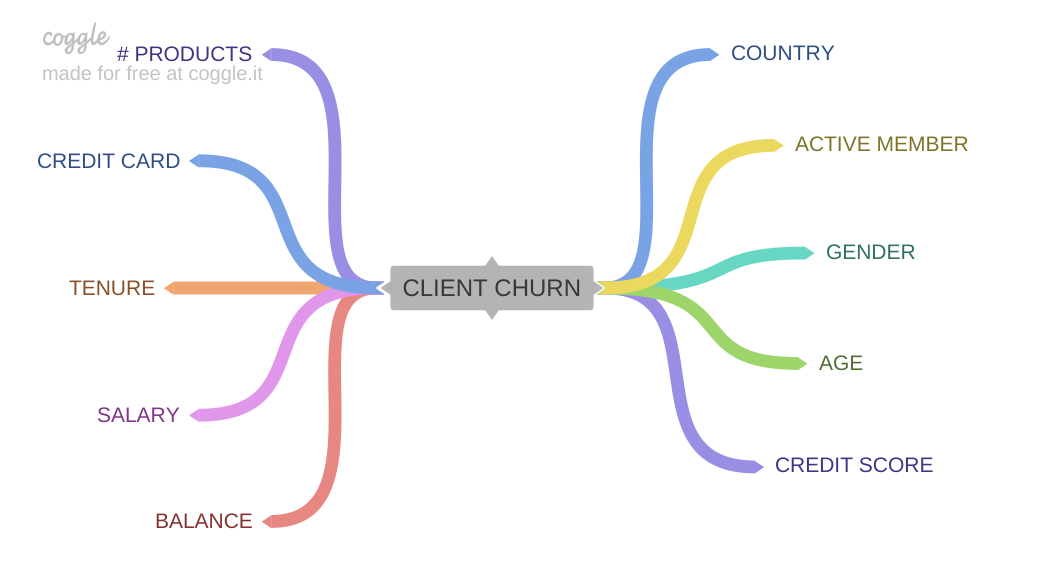

In [131]:
Image('images/CLIENT_CHURN.png')

# Exploratory Data Analysis

In [132]:
df4 = df3.copy()

## Numerical Features

In [133]:
mask = (df4.exited == 1)

### Distributions

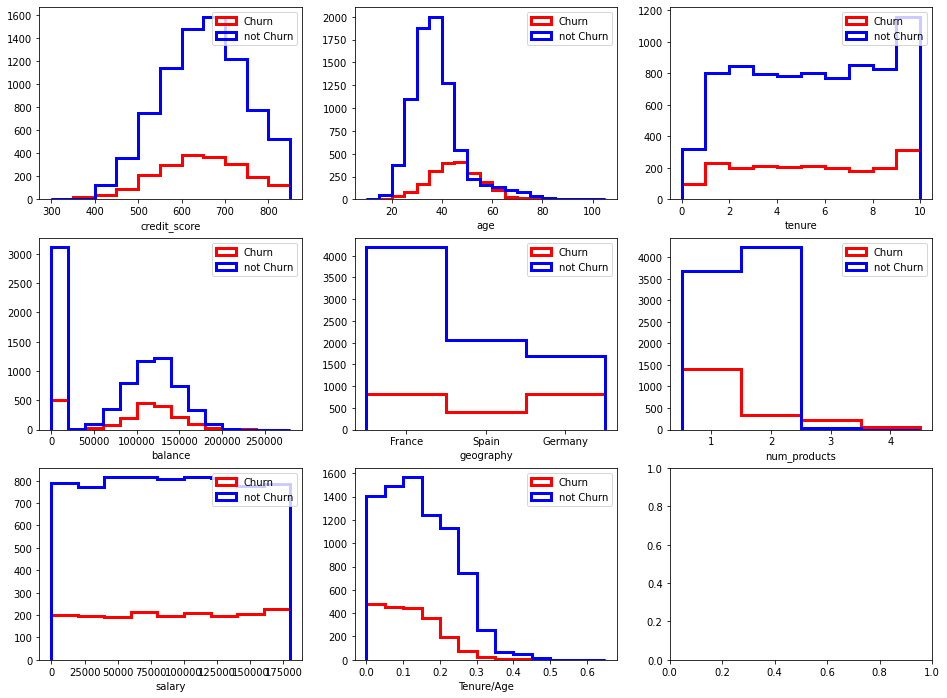

In [134]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

cols = ['credit_score', 'age', 'tenure',
        'balance', 'geography', 'num_products',
        'salary']
bins = [np.arange(300, 900, 50), np.arange(10, 110, 5), np.arange(0, 11, 1),
        np.arange(0, 300_000, 20_000), np.arange(-0.5, 3.5, 1), np.arange(.5, 5.5, 1),
        np.arange(0, 200_000, 20_000)]

normed = False
for iax, col, ibin in zip(ax.ravel(), cols, bins):
    plot_hist(iax, df4, col, ibin, normed, mask=mask)
    
ibin = np.arange(0, 0.7, 0.05)
ax[2, 1].hist(df4.tenure[mask] / df4.age[mask], **hargs(bins=ibin, normed=normed))
ax[2, 1].hist(df4.tenure[~mask] / df4.age[~mask], **hargs(bins=ibin, normed=normed, c='b', label='not Churn'))
ax[2, 1].set_xlabel('Tenure/Age')
ax[2, 1].legend()

plt.show()

### Normalized Distributions

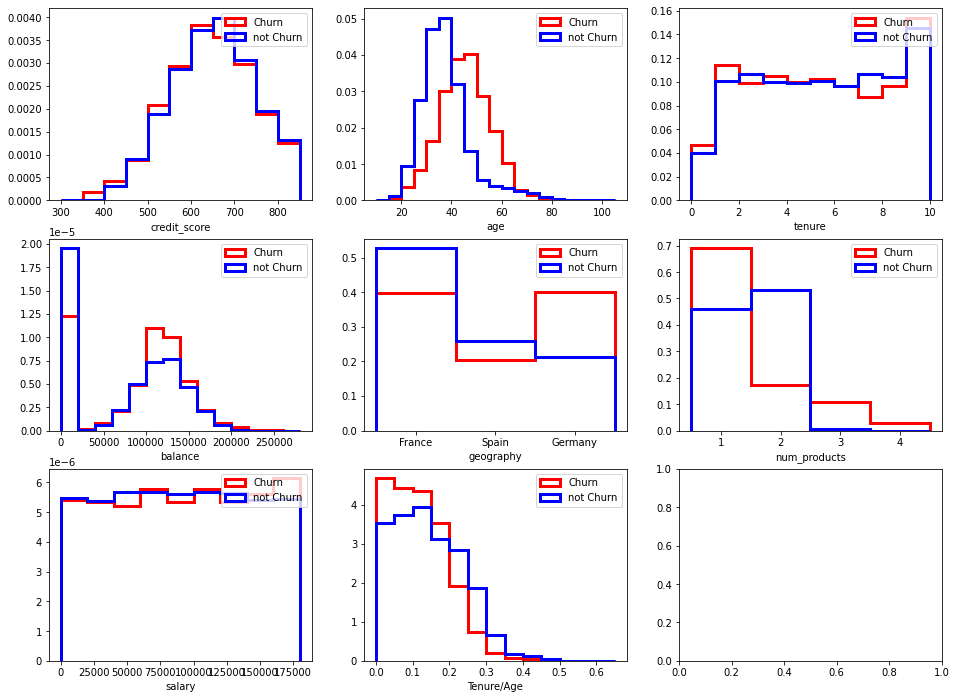

In [135]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))

normed = True
for iax, col, ibin in zip(ax.ravel(), cols, bins):
    plot_hist(iax, df4, col, ibin, normed, mask=mask)
    
ibin = np.arange(0, 0.7, 0.05)
ax[2, 1].hist(df4.tenure[mask] / df4.age[mask], **hargs(bins=ibin, normed=normed))
ax[2, 1].hist(df4.tenure[~mask] / df4.age[~mask], **hargs(bins=ibin, normed=normed, c='b', label='not Churn'))
ax[2, 1].set_xlabel('Tenure/Age')
ax[2, 1].legend()

plt.show()

### Distributions by Country

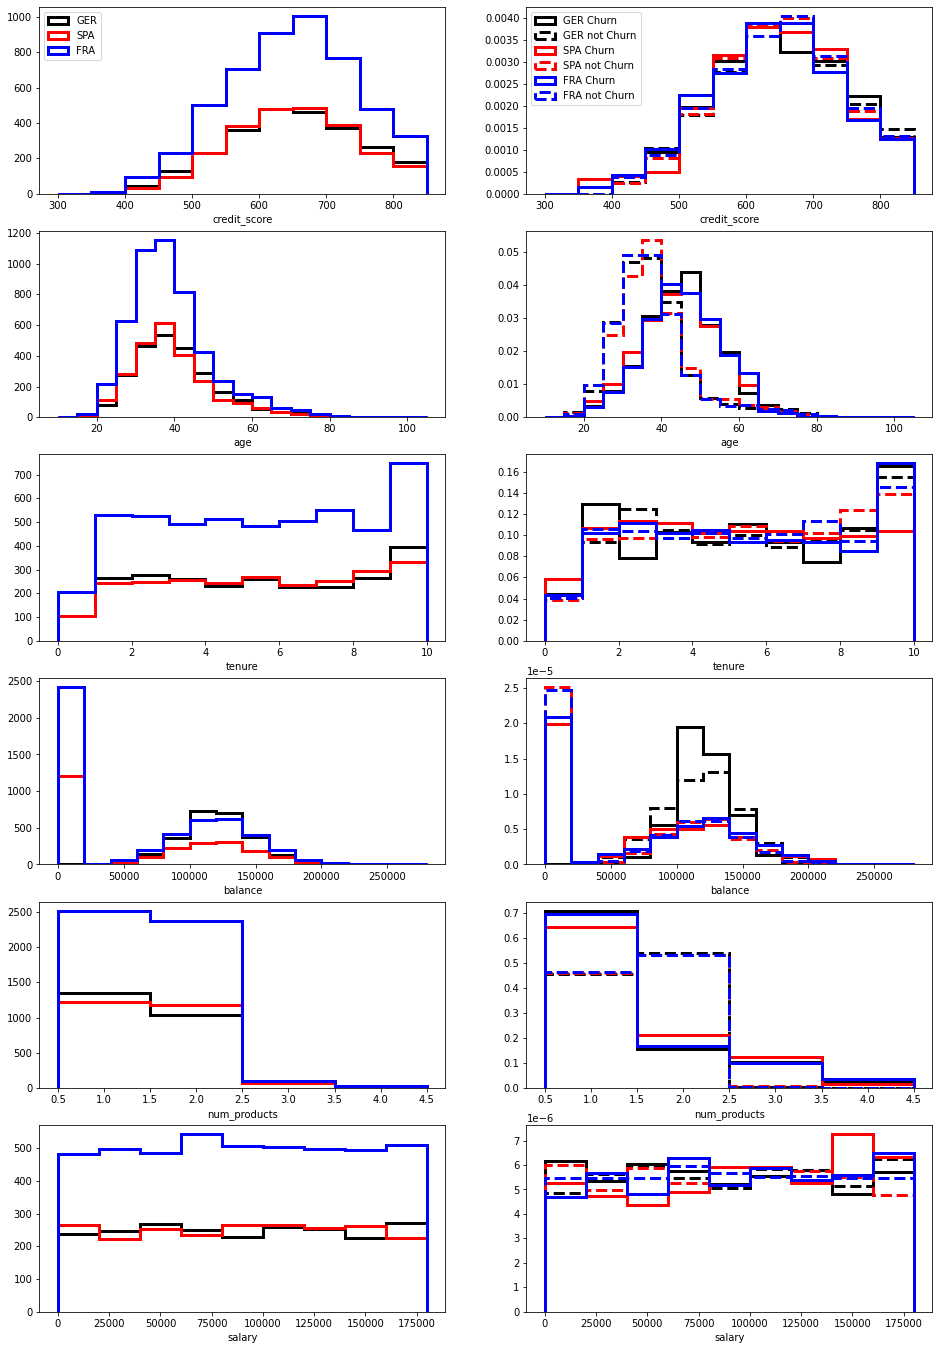

In [136]:
cols = ['credit_score', 'age', 'tenure',
        'balance', 'num_products', 'salary']
bins = [np.arange(300, 900, 50), np.arange(10, 110, 5), np.arange(0, 11, 1),
        np.arange(0, 300_000, 20_000), np.arange(.5, 5.5, 1), np.arange(0, 200_000, 20_000)]

fig, ax = plt.subplots(nrows=len(cols), ncols=2, figsize=(16, 4*len(cols)))
for i, (col, ibin) in enumerate(zip(cols, bins)):
    plot_by_country(ax[i, 0], ax[i, 1], df4, col, ibin)

plt.show()

In [68]:
df4.loc[(df4.balance < 2000)&(df4.geography == 'Germany')]

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country


###  Distributions of Churn and Not Churn Ratio

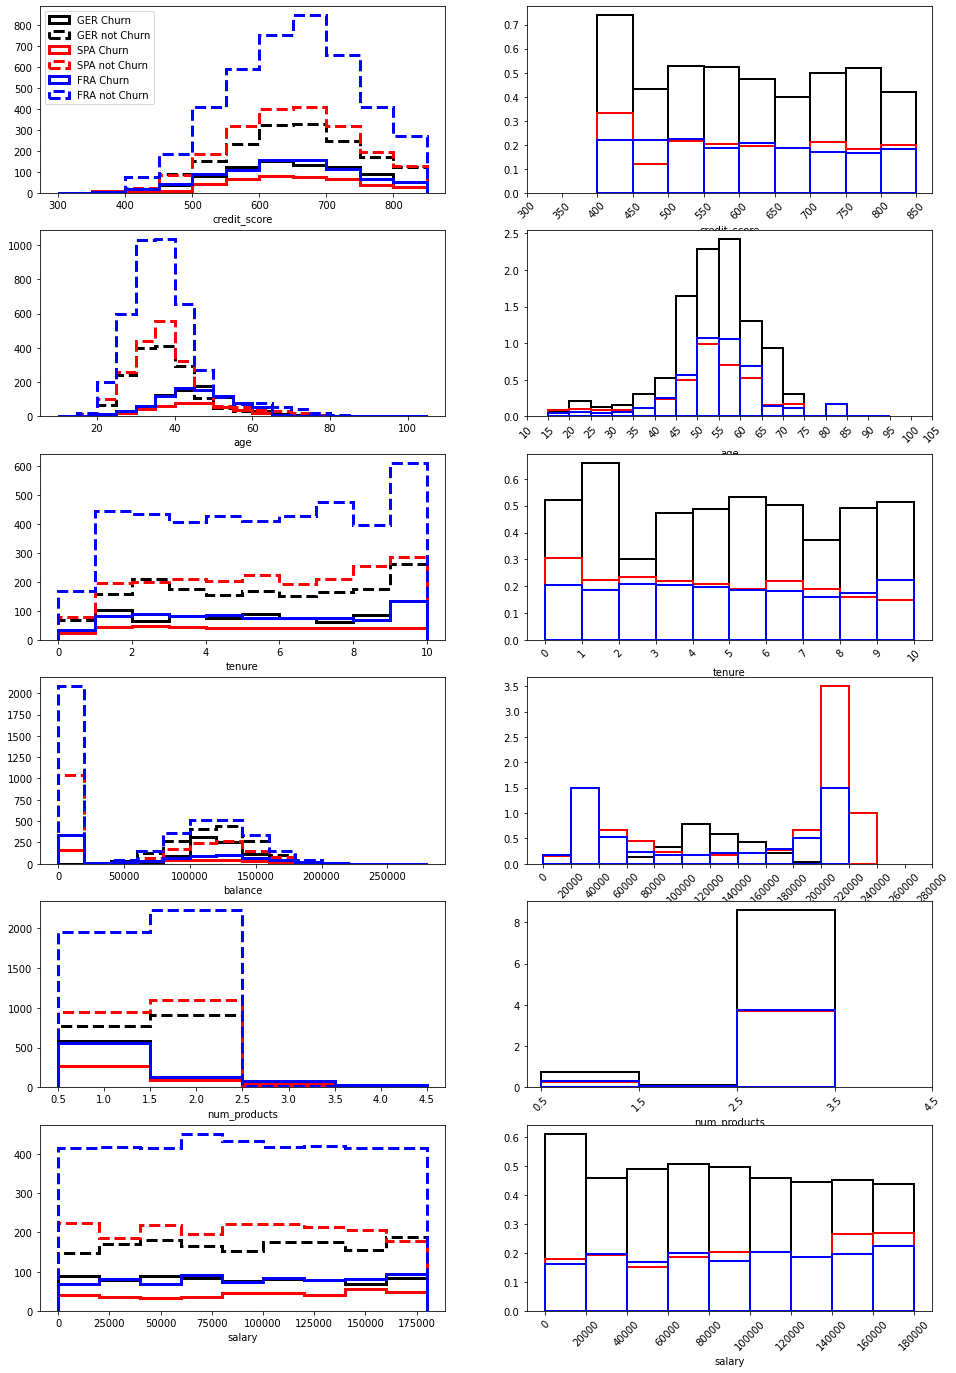

In [137]:
cols = ['credit_score', 'age', 'tenure',
        'balance', 'num_products', 'salary']
bins = [np.arange(300, 900, 50), np.arange(10, 110, 5), np.arange(0, 11, 1),
        np.arange(0, 300_000, 20_000), np.arange(.5, 5.5, 1), np.arange(0, 200_000, 20_000)]

fig, ax = plt.subplots(nrows=len(cols), ncols=2, figsize=(16, 4*len(cols)))
for i, (col, ibin) in enumerate(zip(cols, bins)):
    plot_ratios(ax[i, 0], ax[i, 1], df4, col, ibin)

plt.show()

### Correlation Matrices

In [141]:
attributes = ['age', 'balance', 'tenure', 'num_products',
              'credit_score', 'salary', 'country',
              'credit_card', 'active_member', 'gender']

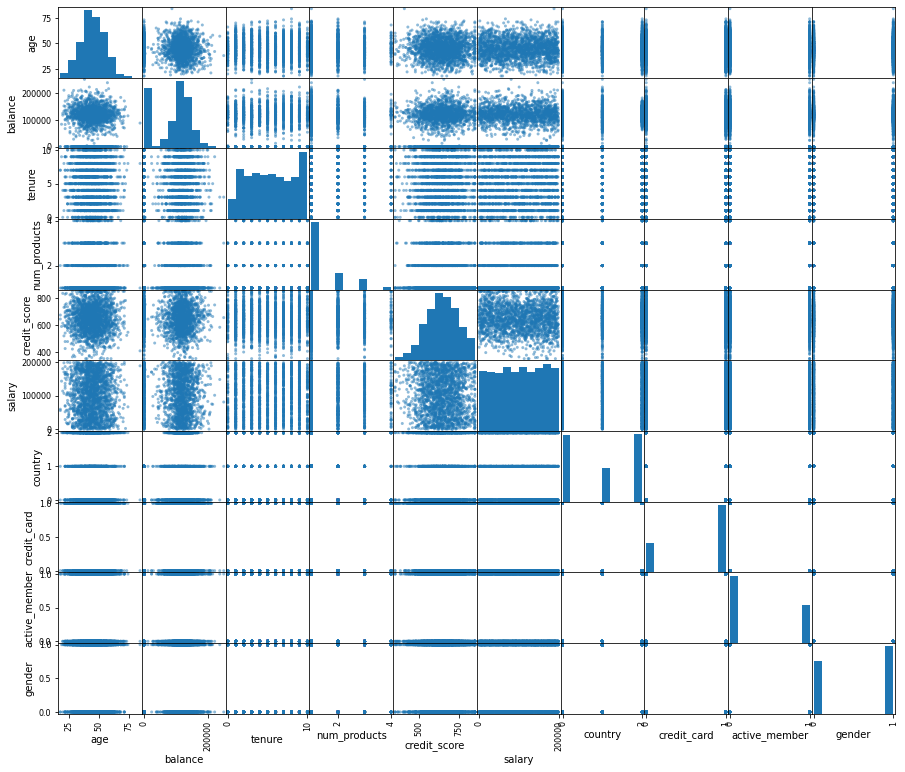

In [142]:
scatter_matrix(df4[mask][attributes], figsize=(15, 13))
plt.show()

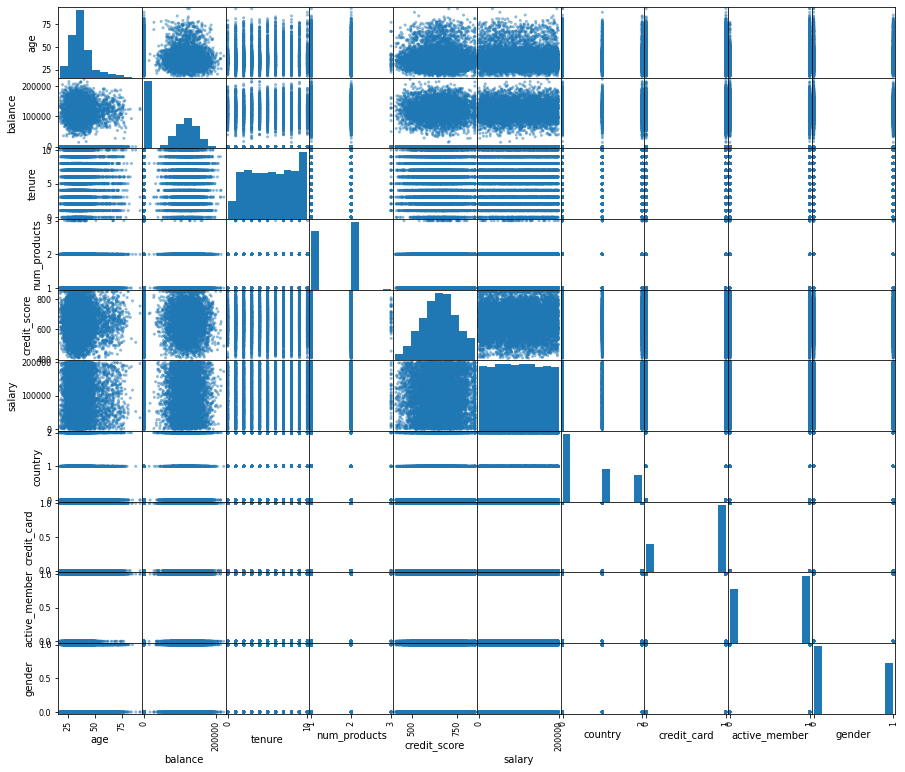

In [143]:
scatter_matrix(df4[~mask][attributes], figsize=(15, 13))
plt.show()

## Categorical Features

### Correlations with Numerical Features

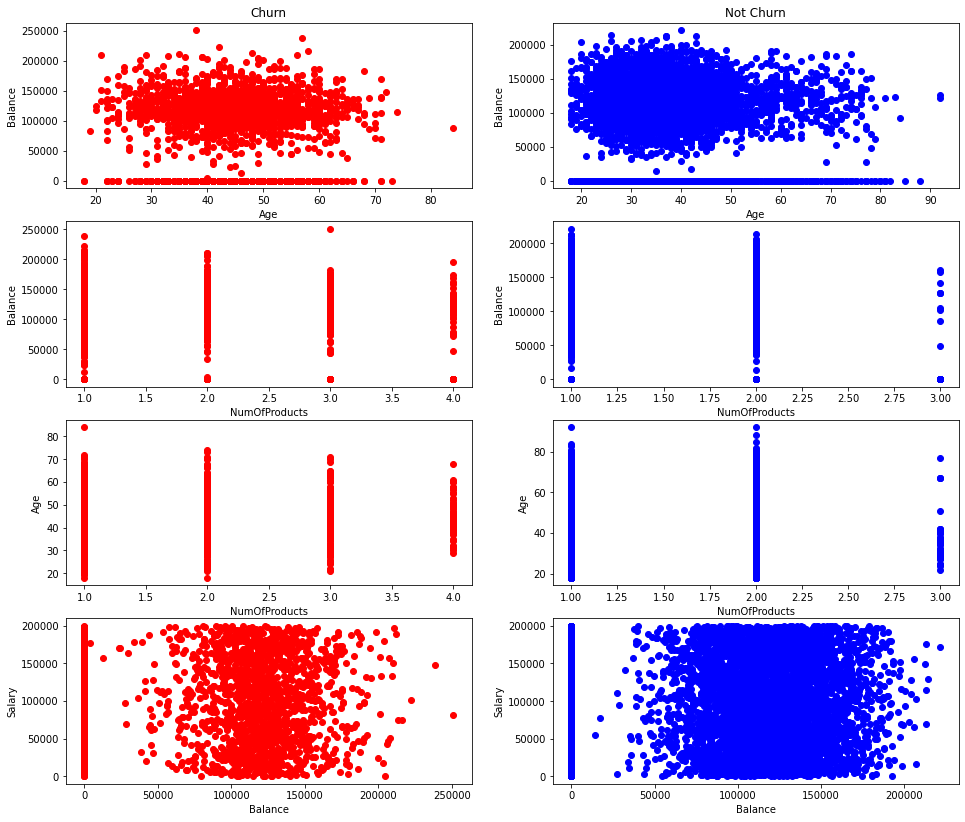

In [73]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 14))
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = ax

ax1.scatter(x=df4.age[mask], y=df4.balance[mask], label='Churn', color='r')  
ax1.set_title('Churn')
ax1.set_xlabel('Age')
ax1.set_ylabel('Balance')

ax2.scatter(x=df4.age[~mask], y=df4.balance[~mask], label='not Churn', color='b')
ax2.set_title('Not Churn')
ax2.set_xlabel('Age')
ax2.set_ylabel('Balance')

ax3.scatter(x=df4.num_products[mask], y=df4.balance[mask], label='Churn', color='r')  
ax3.set_xlabel('NumOfProducts')
ax3.set_ylabel('Balance')

ax4.scatter(x=df4.num_products[~mask], y=df4.balance[~mask], label='not Churn', color='b')
ax4.set_xlabel('NumOfProducts')
ax4.set_ylabel('Balance')

ax5.scatter(x=df4.num_products[mask], y=df4.age[mask], label='Churn', color='r')  
ax5.set_xlabel('NumOfProducts')
ax5.set_ylabel('Age')

ax6.scatter(x=df4.num_products[~mask], y=df4.age[~mask], label='not Churn', color='b')
ax6.set_xlabel('NumOfProducts')
ax6.set_ylabel('Age')

ax7.scatter(x=df4.balance[mask], y=df4.salary[mask], label='Churn', color='r')
ax7.set_xlabel('Balance')
ax7.set_ylabel('Salary')

ax8.scatter(x=df4.balance[~mask], y=df4.salary[~mask], label='not Churn', color='b')
ax8.set_xlabel('Balance')
ax8.set_ylabel('Salary')

plt.show()

### Frequency Tables

In [144]:
table = df4.groupby(['exited', 'credit_card']).agg('count').balance.unstack()
print_prop(table)
table

Total of credit_card = 10000
Proportion of credit_card==0: 29.45%
Proportion of credit_card==1: 70.55%
Proportion of credit_card==0 that Churned: 20.81%
Proportion of credit_card==1 that Churned: 20.18%


credit_card,0,1
exited,,
0,2332,5631
1,613,1424


In [75]:
# 0: Male, 1: Female
table = df4.groupby(['exited', 'gender']).agg('count').balance.unstack()
print_prop(table)
table

Total of gender = 10000
Proportion of gender==0: 54.57%
Proportion of gender==1: 45.43%
Proportion of gender==0 that Churned: 16.46%
Proportion of gender==1 that Churned: 25.07%


gender,0,1
exited,,
0,4559,3404
1,898,1139


In [76]:
table = df4.groupby(['exited', 'active_member']).agg('count').balance.unstack()
print_prop(table)
table

Total of active_member = 10000
Proportion of active_member==0: 48.49%
Proportion of active_member==1: 51.51%
Proportion of active_member==0 that Churned: 26.85%
Proportion of active_member==1 that Churned: 14.27%


active_member,0,1
exited,,
0,3547,4416
1,1302,735


In [77]:
table = df4.groupby(['exited', 'geography']).agg('count').balance.unstack()
print_prop3(table)
table

Total of geography = 10000
Proportion of France: 50.14%
Proportion of Spain: 24.77%
Proportion of Germany: 25.09%
Proportion of France that Churned: 16.15%
Proportion of Spain that Churned: 16.67%
Proportion of Germany that Churned: 32.44%


geography,France,Germany,Spain
exited,,,
0,4204,1695,2064
1,810,814,413


### Frequency Plots

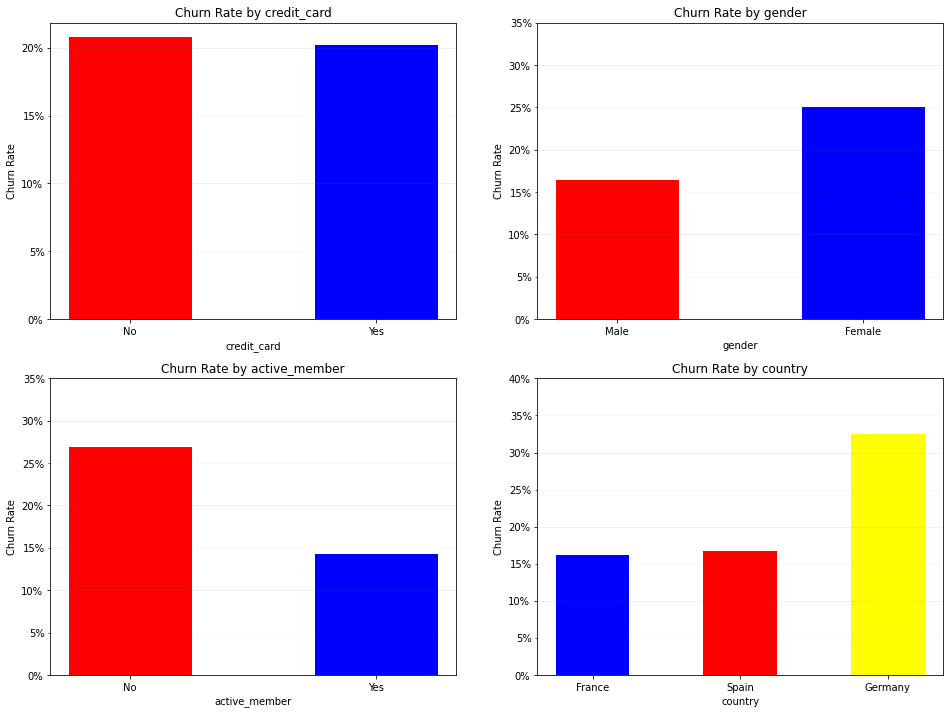

In [78]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = ax

cols = ['credit_card', 'gender', 'active_member', 'country']
for iax, col, ymax in zip(ax.ravel(), cols, [.3, .4, .4, .5]):
    draw_rate(iax, df4, col)
    draw_grid(iax, ymax)
    
plt.show()

### Frequency Plots by Country

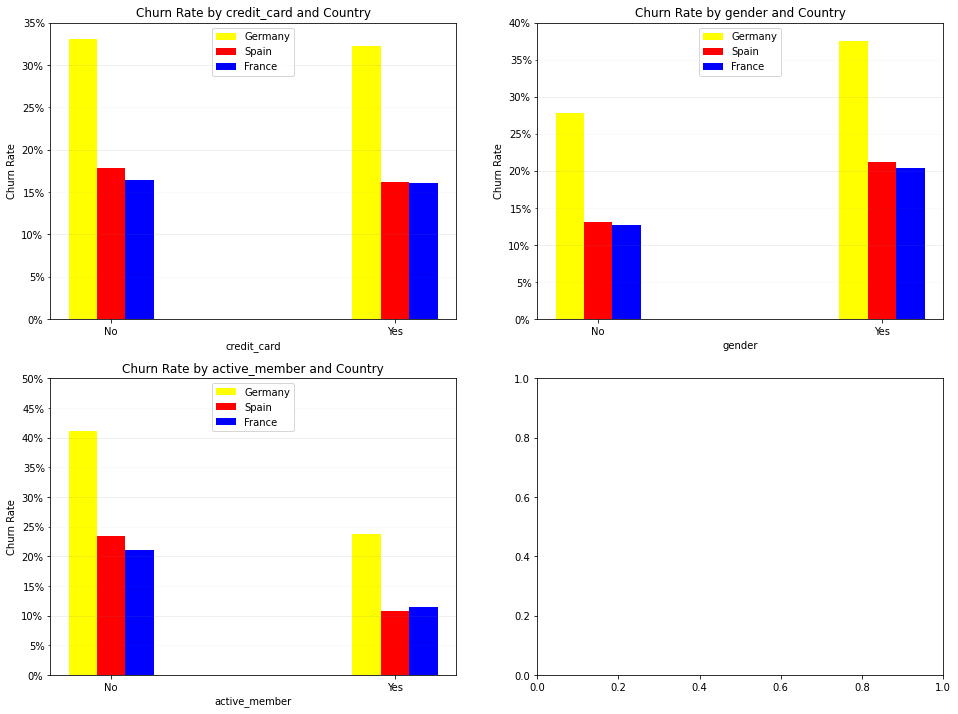

In [93]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = ax

cols = ['credit_card', 'gender', 'active_member']
for iax, col, ymax in zip(ax.ravel(), cols, [.4, .5, .6]):
    draw_rate_country(iax, df4, col)
    draw_grid(iax, ymax)


plt.show()

# Data Preparation

In [94]:
df5 = df4.copy()

## Normalization

In [95]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

In [96]:
data = df5[cols_norm].copy()
scaler.fit(data)
df5[cols_norm] = scaler.transform(data)

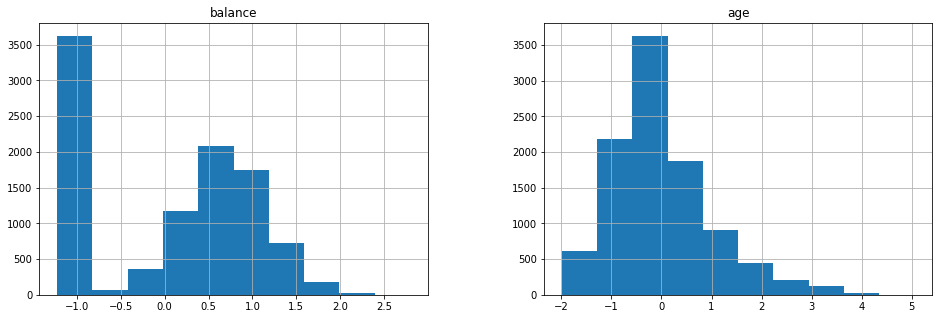

In [97]:
df5[cols_norm].hist(figsize=(16,5));

## Rescaling

In [98]:
cols_mms = ['credit_score', 'tenure', 'salary']
mms = MinMaxScaler()

In [99]:
data = df5[cols_mms].copy()
mms.fit(data)
df5[cols_mms] = mms.transform(data)

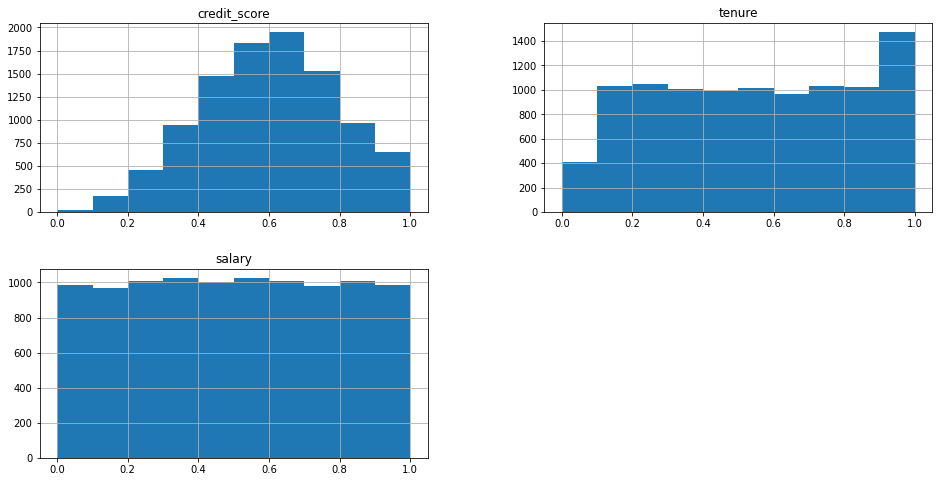

In [100]:
df5[cols_mms].hist(figsize=(16,8));

## Transformation

### Encoding

In [172]:
cols_ohe = ['geography', 'gender']
#cols_ohe = ['geography']
ohe = OneHotEncoder(sparse=False)

In [178]:
df5[cols_ohe].head(10)

,geography,gender
0,France,1
1,Spain,1
2,France,1
3,France,1
4,Spain,1
5,Spain,0
6,France,0
7,Germany,1
8,France,0
9,France,0


In [176]:
ohe.fit_transform(df5[cols_ohe])[:10]

array([[1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.]])

## Combining All Column Transformations

In [ ]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

cols_mms = ['credit_score', 'tenure', 'salary']
mms = MinMaxScaler()

cols_ohe = ['geography', 'gender']
ohe = OneHotEncoder(drop='if_binary')

ct = make_column_transformer((scaler, cols_norm), (mms, cols_mms), (ohe, cols_ohe), remainder='passthrough')

### Testing the Column Transformer

In [153]:
dump = df2.copy()
dump.iloc[[0, 5]]

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,exited,country
0,619,France,1,42,2,0.00,1,1,1,101348.88,1,0
5,645,Spain,0,44,8,113755.78,2,1,0,149756.71,1,1


In [154]:
ct.fit_transform(dump)[[0, 5]]

array([[-1.226,  0.294,  0.538,  0.2  ,  0.507,  1.   ,  0.   ,  0.   ,
         1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  0.   ],
       [ 0.597,  0.484,  0.59 ,  0.8  ,  0.749,  0.   ,  0.   ,  1.   ,
         0.   ,  2.   ,  1.   ,  0.   ,  1.   ,  1.   ]])

In [157]:
ct.named_transformers_['onehotencoder'].get_feature_names()

array(['x0_France', 'x0_Germany', 'x0_Spain', 'x1_1'], dtype=object)

In [ ]:
model_cols = ['balance', 'age', 'credit_score', 'tenure', 'salary', 'france', 'germany', 'spain',
              'gender', 'num_products', 'credit_card', 'active_member']

# Machine Learning Models

In [10]:
df6 = reload_data()
print(', '.join(df6.columns))

credit_score, geography, gender, age, tenure, balance, num_products, credit_card, active_member, salary, exited


In [11]:
X = df6.drop('exited', axis=1).copy()
y = df6.exited.copy()

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=True, stratify=y)

## Train Set Churn Rate - Pergunta 1: Qual a taxa de Churn atual da empresa?

In [13]:
total_churn = y_train.sum()
churn_ratio = total_churn / len(y_train)

print(f'The total churn rate in the training data set is {100.*churn_ratio:.2f}%')

The total churn rate in the training data set is 20.38%


## Model Comparison - Lift Curves and Churn Rates

### Column Transformer for Pipeline

In [14]:
cols_norm = ['balance', 'age']
scaler = StandardScaler()

cols_mms = ['credit_score', 'tenure', 'salary']
mms = MinMaxScaler()

cols_ohe = ['geography', 'gender']
ohe = OneHotEncoder(drop='if_binary')

ct = make_column_transformer((scaler, cols_norm), (mms, cols_mms), (ohe, cols_ohe), remainder='passthrough')

model_cols = ['balance', 'age', 'credit_score', 'tenure', 'salary', 'france', 'germany', 'spain',
              'gender', 'num_products', 'credit_card', 'active_member']

### Instatiation and Training of Models

In [87]:
lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1,
                        class_weight=None, random_state=42, solver='lbfgs', max_iter=100, multi_class='auto',
                        verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)


rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                            random_state=42, verbose=0, warm_start=False, class_weight=None,
                            ccp_alpha=0.0, max_samples=None)

nb = GaussianNB()

km = KMeans(n_clusters=2)

xg = XGBClassifier()

In [91]:
models = [lr, nb, rf, xg, km]
model_names = ['LogReg', 'GaussianNB', 'RandomForest', 'XGBoost', 'KMeans']
scoring = 'recall'

means = []
stds = []
y_probas = []
ys = []
for model, name in zip(models, model_names):
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    ys.append(pipe.predict(X_train))
    if hasattr(model, 'predict_proba'):
        y_probas.append(pipe.predict_proba(X_train)[:, 1])
    cv = cross_val_score(pipe, X, y, cv=5, scoring=scoring)
    mean, std = cv.mean(), cv.std()
    means.append(mean)
    stds.append(std)
    print(f'{name}: {mean:.3f} +/- {std:.3f}')

LogReg: 0.210 +/- 0.024
GaussianNB: 0.370 +/- 0.017
RandomForest: 0.467 +/- 0.014
XGBoost: 0.494 +/- 0.039
KMeans: 0.557 +/- 0.220


In [92]:
step = .1
rates = []
lifts = []
gains = []

for y_proba in y_probas:
    rates.append(get_rate(y_train, y_proba, step=step))
    lift, gain = get_lift_gain(y_train, y_proba, step=step, plot=False)
    lifts.append(lift)
    gains.append(gain)

### Model Performance

#### Confusion Matrix

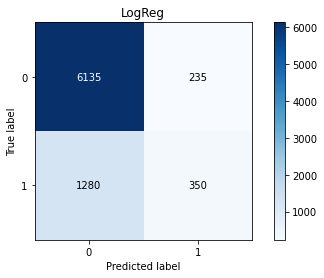

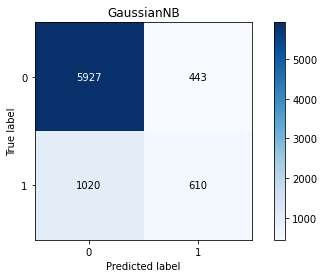

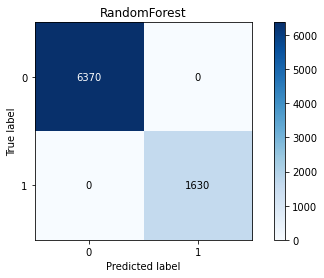

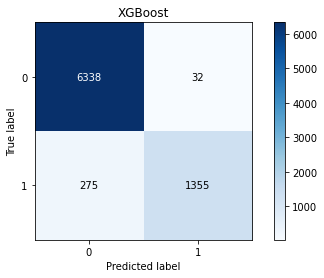

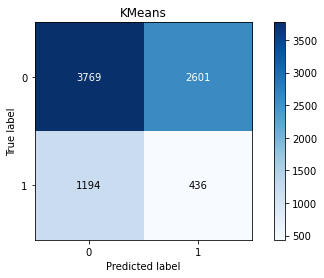

In [96]:
for ypred, model_name in zip(ys, model_names):
    skplt.metrics.plot_confusion_matrix(y_train, ypred, labels=None, true_labels=None,
                                        pred_labels=None, title=model_name, normalize=False,
                                        hide_zeros=False, hide_counts=False, x_tick_rotation=0,
                                        ax=None, figsize=(8,4), cmap='Blues',
                                        title_fontsize='large', text_fontsize='medium')

#### Gains and Lift

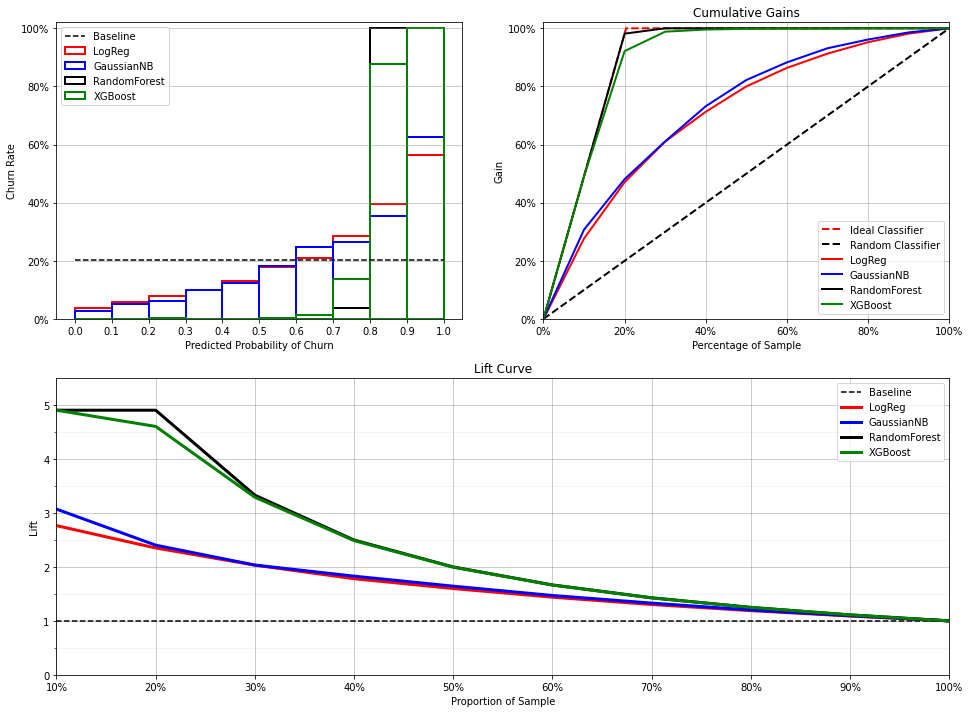

In [94]:
fig = plt.figure(figsize=(16,12))
grid = (2, 2)
ax1 = plt.subplot2grid(grid, (0, 0))
ax2 = plt.subplot2grid(grid, (0, 1))
ax3 = plt.subplot2grid(grid, (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
plot_cum_gain(ax2, gains, model_names, step)
plot_lift(ax3, lifts, model_names, step)

plt.show()

#### Feature Importance

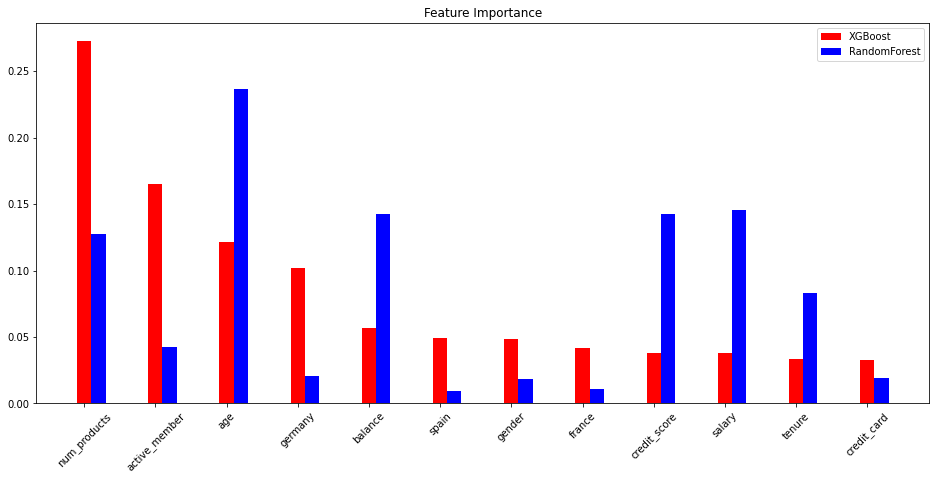

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))

order = np.argsort(xg.feature_importances_)[::-1]
names = np.array(model_cols)[order]

x = np.arange(0, len(names))
ax.bar(x=x, height=xg.feature_importances_[order], color='red', label='XGBoost', width=.2)
ax.bar(x=x+0.2, height=rf.feature_importances_[order], color='blue', label='RandomForest', width=.2)

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45)
ax.set_title(f'Feature Importance')
ax.legend(loc='upper right')

plt.show()

#### Calibration Curves

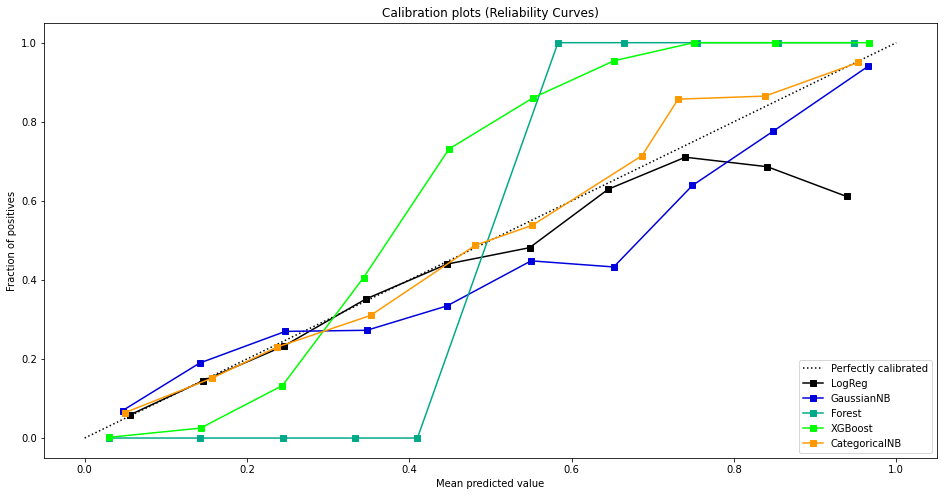

In [239]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

skplt.metrics.plot_calibration_curve(y_train, y_probas, clf_names=model_names, n_bins=10,
                                     title='Calibration plots (Reliability Curves)', ax=ax, figsize=None,
                                     cmap='nipy_spectral', title_fontsize='large', text_fontsize='medium')

plt.show()

## Model Fine Tuning

In [402]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=42,
                                                  shuffle=True, stratify=y_train)

In [406]:
pipe = make_pipeline(ct, xg)
pipe.fit(X_train, y_train)
ypred = pipe.predict(X_val)
yproba = pipe.predict_proba(X_val)[:, 1]

cv = cross_val_score(pipe, X_train, y_train, cv=10, scoring=scoring)
print(f'XGBoost old: {100.*means[-2]:.1f}% +/- {100.*stds[-2]:.1f}%')
print(f'XGBoost new: {100.*cv.mean():.1f}% +/- {100.*cv.std():.1f}%')

In [429]:
cv = cross_val_score(pipe, X_train, y_train, cv=10, scoring=scoring)
print(f'XGBoost old: {100.*means[-2]:.1f}% +/- {100.*stds[-2]:.1f}%')
print(f'XGBoost new: {100.*cv.mean():.1f}% +/- {100.*cv.std():.1f}%')

XGBoost old: 49.4% +/- 3.9%
XGBoost new: 48.4% +/- 3.7%


In [433]:
model = xg
model_names = ['XGB-Train', 'XGB-Val']
scoring = 'recall'

step = .1

ys = []
y_probas = []
rates = []
lifts = []
gains = []
for (X_set, y_set), name in zip([(X_train, y_train), (X_val, y_val)], model_names):
    ys.append(pipe.predict(X_set))
    y_proba = pipe.predict_proba(X_set)[:, 1]
    y_probas.append(y_proba)
    rates.append(get_rate(y_set, y_proba, step=step))
    lift, gain = get_lift_gain(y_set, y_proba, step=step, plot=False)
    lifts.append(lift)
    gains.append(gain)

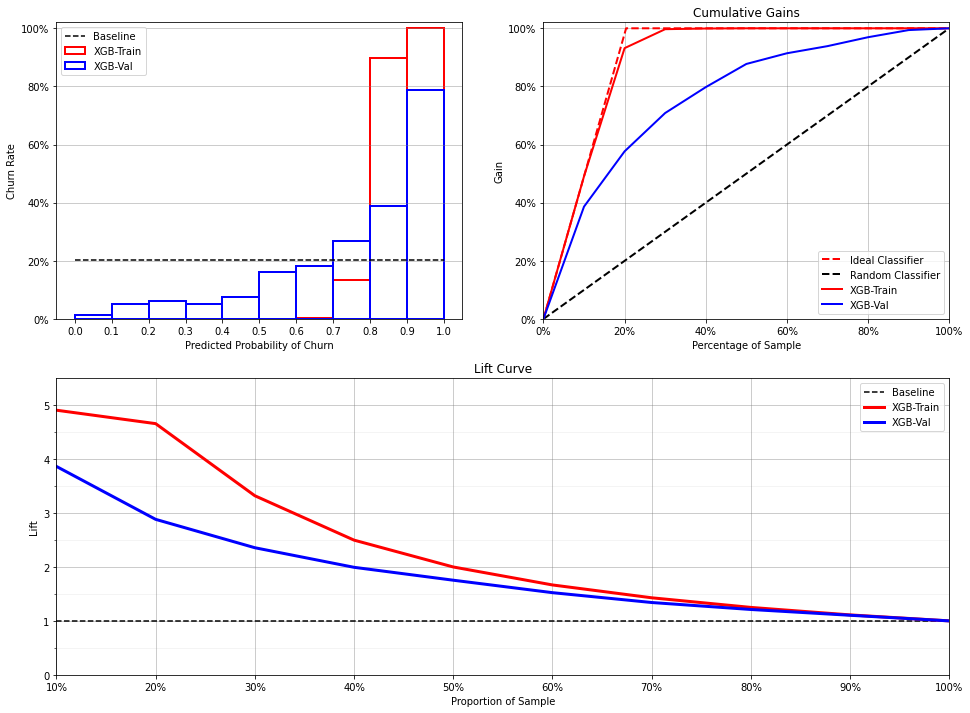

In [434]:
fig = plt.figure(figsize=(16,12))
grid = (2, 2)
ax1 = plt.subplot2grid(grid, (0, 0))
ax2 = plt.subplot2grid(grid, (0, 1))
ax3 = plt.subplot2grid(grid, (1, 0), colspan=2)

plot_rates(ax1, rates, model_names, step)
plot_cum_gain(ax2, gains, model_names, step)
plot_lift(ax3, lifts, model_names, step)

plt.show()

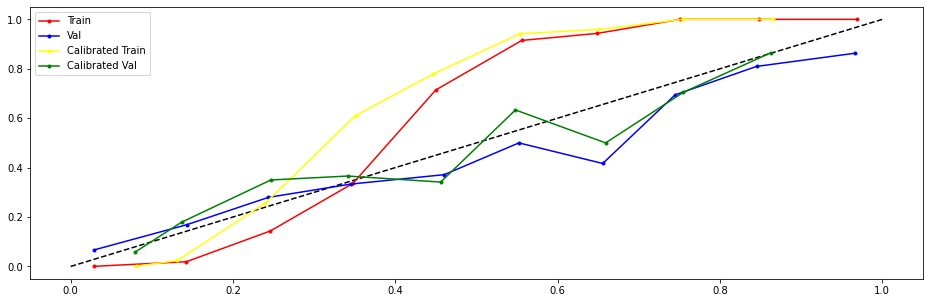

In [514]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

model = pipe.named_steps['xgbclassifier']
x = pipe.named_steps['columntransformer'].transform(X_val)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

ax.plot([0, 1], [0, 1], linestyle='--', color='black')
fop, mpv = calibration_curve(y_train, y_probas[0], n_bins=10)
ax.plot(mpv, fop, marker='.', color='red', label='Train')
fop, mpv = calibration_curve(y_val, y_probas[1], n_bins=10)
ax.plot(mpv, fop, marker='.', color='blue', label='Val')

calibrator = CalibratedClassifierCV(model, cv='prefit')
calibrator.fit(x, y_val)

probs = calibrator.predict_proba(pipe.named_steps['columntransformer'].transform(X_train))[:, 1]
fop, mpv = calibration_curve(y_train, probs, n_bins=10)
ax.plot(mpv, fop, marker='.', color='yellow', label='Calibrated Train')

probs = calibrator.predict_proba(x)[:, 1]
fop, mpv = calibration_curve(y_val, probs, n_bins=10)
ax.plot(mpv, fop, marker='.', color='green', label='Calibrated Val')


ax.legend()

plt.show()

### tests of ROI

In [617]:
for i in [.5, .6, .7, .8]:
    print(f'Threshold set at {i}:')
    roi_xg = ROI(X_val, y_val, yproba, threshold=i, name='XGBoost')
    roi_xg.print_performance(investment=investment, gift=gift)
    print('\n\n')

Threshold set at 0.5:
100
Performance of XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,651,373.54
Percentage of 100 clientes that were correctly identified as churning clients: 84.0%

Performance of selecting the 100 richest clients (with Pchurn > 0.5):
ROI = $2,281,967.55
Percentage of 100 clientes that were correctly identified as churning clients: 75.0%

Performance of randomly selecting 100 clients:
ROI = $202,648.64
Percentage of 100 clientes that were correctly identified as churning clients: 19.0%

Performance of realisticaly selecting clients:
ROI = $2,154,124.39
Percentage of 153 clientes that were correctly identified as churning clients: 67.3%
Total invested: 10000



Threshold set at 0.6:
100
Performance of XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,651,373.54
Percentage of 100 clientes that were correctly identified as churning clients: 84.0%

Performance of selecting the 100 richest clients (with Pchurn > 0.

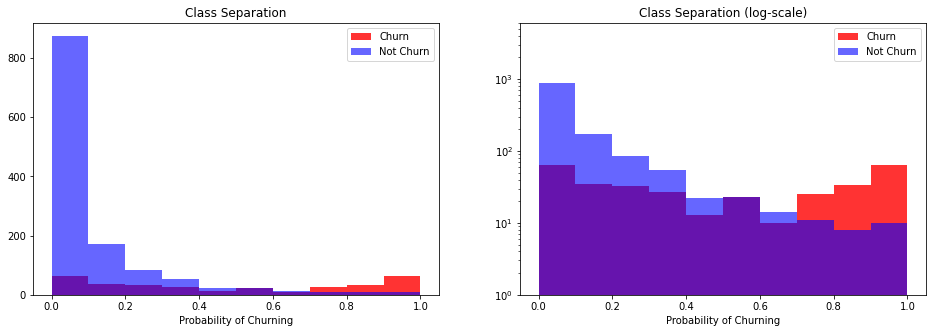

In [421]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

df = roi_xg.df

mask = (df.true==1)
bins = np.arange(0, 1.1, .1)
ax1.hist(df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 6000)
ax2.legend()

plt.show()

# Prediction Analysis - ROI

In [543]:
test = ROI(X_val, y_val, yproba, threshold=.7, name='XGBoost')
test.print_performance(investment=investment, gift=gift)

100
Performance of XGBoost - selecting the 100 clients with highest churn probability:
ROI = $1,651,373.54
Percentage of 100 clientes that were correctly identified as churning clients: 84.0%

Performance of selecting the 100 richest clients (with Pchurn > 0.8):
ROI = $1,906,434.41
Percentage of 100 clientes that were correctly identified as churning clients: 88.0%

Performance of randomly selecting 100 clients:
ROI = $337,966.99
Percentage of 100 clientes that were correctly identified as churning clients: 22.0%


In [544]:
test.make_gift()

In [597]:
test.df[test.df.churn == 1]

,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,true,pred,LTV,churn,gift
8493,753,Germany,Female,46,9,113909.69,3,1,0,92320.37,1,0.999795,13848.06,1,20000
8923,625,Germany,Female,55,8,118772.71,4,0,0,135853.62,1,0.999776,27170.72,1,20000
2495,466,Germany,Female,56,2,111920.13,3,1,0,197634.11,1,0.999673,39526.82,1,20000
566,438,Spain,Female,54,2,0.00,1,0,0,191763.07,1,0.999442,38352.61,1,20000
4174,568,France,Male,51,4,0.00,3,1,1,66586.56,0,0.999193,9987.98,1,20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,680,Germany,Female,51,5,143139.87,1,0,0,47795.43,1,0.820178,7169.31,1,50
4021,772,Germany,Female,48,6,108736.52,1,1,0,184564.67,1,0.813579,36912.93,1,50
4697,537,Germany,Male,48,4,131834.80,1,1,0,166476.95,1,0.811798,33295.39,1,50
4864,737,France,Male,54,9,0.00,1,1,0,83470.40,1,0.806578,12520.56,1,50


In [598]:
gifts = test.df[test.df.churn == 1]

W = int(10_000 / 50)
vals = gifts.LTV.astype(int).values
wt = gifts.gift
wt = (wt/50).astype(int).values

In [599]:
max_val, keep = knapsack(W, wt, vals)

In [600]:
print(f'{max_val:,}')

1,529,570


In [601]:
cols = ['true', 'pred', 'LTV', 'gift']
gifts[keep][cols]

,true,pred,LTV,gift
1201,1,0.989544,27998.94,200
3610,1,0.987390,21383.73,200
5900,0,0.987085,32622.68,200
2459,1,0.986371,11843.37,200
8253,1,0.985147,3975.04,200
...,...,...,...,...
3119,1,0.820178,7169.31,50
4021,1,0.813579,36912.93,50
4697,1,0.811798,33295.39,50
4864,1,0.806578,12520.56,50


In [604]:
gifts[keep].gift.sum()

9300

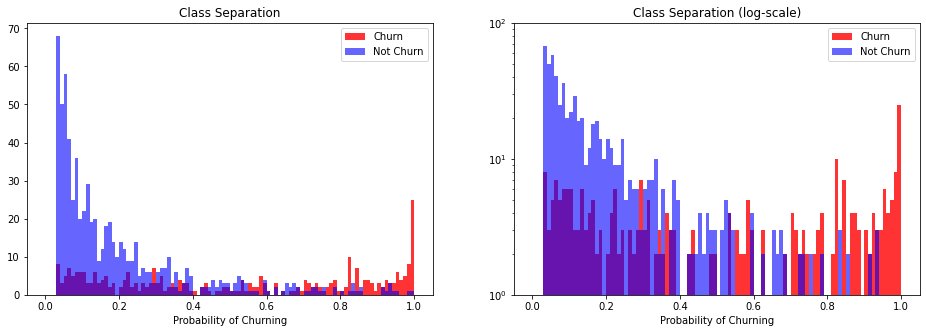

In [465]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

df = roi_xg.df.iloc[:1000]

mask = (df.true==1)
step = .01
bins = np.arange(0, 1. + step, step)
ax1.hist(df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 100)
ax2.legend()

plt.show()

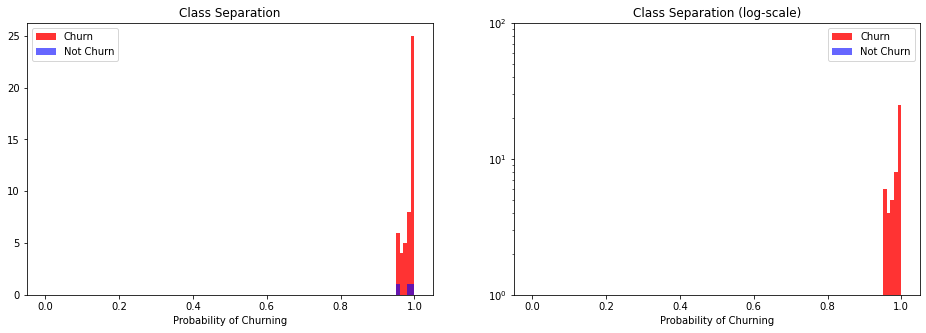

In [475]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

df = roi_xg.df

cut = (df.pred > .95)
mask = (df.true==1)
step = .01
bins = np.arange(0, 1. + step, step)
ax1.hist(df.loc[cut][mask].pred, bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(df.loc[cut][~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(df.loc[cut][mask].pred, bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(df.loc[cut][~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 100)
ax2.legend()

plt.show()

In [480]:
dump = df.loc[df.pred>=0.95]
print(dump.true.sum(),'out of',  len(dump))
dump

48 out of 51


,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,true,pred,LTV,churn
8493,753,Germany,Female,46,9,113909.69,3,1,0,92320.37,1,0.999795,13848.06,1
8923,625,Germany,Female,55,8,118772.71,4,0,0,135853.62,1,0.999776,27170.72,1
2495,466,Germany,Female,56,2,111920.13,3,1,0,197634.11,1,0.999673,39526.82,1
566,438,Spain,Female,54,2,0.00,1,0,0,191763.07,1,0.999442,38352.61,1
4174,568,France,Male,51,4,0.00,3,1,1,66586.56,0,0.999193,9987.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,815,France,Female,56,3,0.00,3,1,1,94248.16,1,0.957054,14137.22,1
4071,850,Spain,Female,54,4,120952.74,1,1,0,66963.15,0,0.956884,10044.47,1
7517,586,France,Male,58,7,151933.63,1,1,0,162960.05,1,0.956239,32592.01,1
4612,748,France,Female,49,7,29602.08,1,0,0,163550.58,1,0.952314,32710.12,1


In [483]:
dump = df.loc[(df.pred>=0.85) & (df.pred<.95)]
print(dump.true.sum(),'out of',  len(dump))
dump

28 out of 37


,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,true,pred,LTV,churn
4380,438,Germany,Male,59,7,127197.14,1,1,0,51565.98,1,0.948334,7734.90,1
7853,730,France,Female,47,7,0.00,1,1,0,33373.26,1,0.942958,5005.99,1
7058,624,France,Female,71,4,170252.05,3,1,1,73679.59,1,0.941437,11051.94,1
2224,631,Spain,Male,55,9,99685.06,1,1,0,114474.98,0,0.940951,22895.00,1
7803,619,Germany,Female,52,8,124099.13,1,0,0,23904.52,0,0.939734,3585.68,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,516,France,Female,46,6,62212.29,1,0,1,171681.86,1,0.861390,34336.37,1
5494,383,Spain,Female,48,8,95808.19,1,0,0,137702.01,1,0.860829,27540.40,1
6104,736,Germany,Male,50,9,116309.01,1,1,0,185360.40,1,0.857767,37072.08,1
5566,633,Germany,Male,42,3,126041.02,1,0,1,11796.89,0,0.854114,1769.53,1


In [482]:
dump = df.loc[(df.pred>=0.85) & (df.pred<.90)]
print(dump.true.sum(),'out of',  len(dump))
dump

13 out of 15


,credit_score,geography,gender,age,tenure,balance,num_products,credit_card,active_member,salary,true,pred,LTV,churn
3803,850,Germany,Male,51,4,124425.99,1,0,0,118545.49,1,0.897479,23709.10,1
1631,350,Spain,Male,54,1,152677.48,1,1,1,191973.49,1,0.888712,38394.70,1
8343,849,Germany,Female,49,9,132934.89,1,1,0,171056.65,1,0.887846,34211.33,1
8163,768,Germany,Male,48,3,122831.58,1,1,1,24533.89,1,0.880234,3680.08,1
6354,660,Spain,Female,42,5,0.00,3,1,1,189016.24,1,0.879866,37803.25,1
8200,767,Spain,Male,47,5,0.00,1,1,0,121964.46,1,0.878610,24392.89,1
58,511,Spain,Female,66,4,0.00,1,1,0,1643.11,1,0.874896,246.47,1
7158,434,Germany,Male,55,8,109339.17,2,1,0,96405.88,1,0.874869,14460.88,1
3559,650,France,Female,64,7,142028.36,1,1,0,32275.09,1,0.865806,4841.26,1
3085,734,France,Female,54,3,0.00,1,1,0,130805.54,1,0.863373,26161.11,1


In [379]:
roi_xg = ROI(X_train, y_train, y_probas[-1], threshold=0.8, name='XGBoost')
roi_xg.print_performance(investment=investment, gift=gift)

100
Performance of XGBoost - selecting the 100 clients with highest churn probability:
ROI = $2,242,880.79
Percentage of 100 clientes that were correctly identified as churning clients: 100.0%

Performance of selecting the 100 richest clients (with Pchurn > 0.8):
ROI = $19,033,505.17
Percentage of 100 clientes that were correctly identified as churning clients: 100.0%

Performance of randomly selecting 100 clients:
ROI = $214,050.34
Percentage of 100 clientes that were correctly identified as churning clients: 15.0%


In [354]:
investment = 10_000
gift = 100roi_xg = ROI(X_train, y_train, y_probas[-1], threshold=0.8, name='XGBoost')
roi_xg.print_performance(investment=investment, gift=gift)

NEED TO CHANGE THIS    
need to pass xtest after model tunning is done.

In [355]:
roi_xg = ROI(X_train, y_train, y_probas[-1], threshold=0.8, name='XGBoost')
roi_xg.print_performance(investment=investment, gift=gift)

UnboundLocalError: local variable 'i' referenced before assignment

In [333]:
gifted = roi.df[['pred', 'churn', 'true', 'LTV']].head(100)

In [334]:
gifted.true.sum()

100

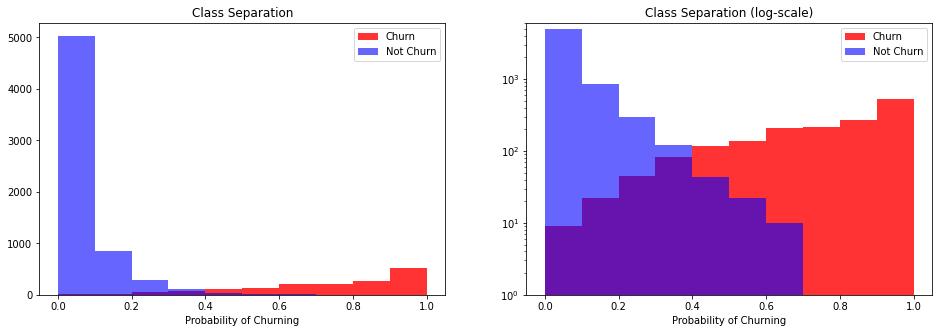

In [401]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

mask = (roi.df.true==1)
bins = np.arange(0, 1.1, .1)
ax1.hist(roi_xg.df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8)
ax1.hist(roi_xg.df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6)
ax1.set_title('Class Separation')
ax1.set_xlabel('Probability of Churning')
ax1.legend()

ax2.hist(roi_xg.df.loc[mask].pred, bins=bins, color='red', label='Churn', alpha=.8, log=True)
ax2.hist(roi_xg.df.loc[~mask].pred, bins=bins, color='blue', label='Not Churn', alpha=.6, log=True)
ax2.set_title('Class Separation (log-scale)')
ax2.set_xlabel('Probability of Churning')
ax2.set_ylim(1, 6000)
ax2.legend()

plt.show()

In [ ]:
# pipe.named_steps.keys()

# params = {}
# params['randomforestclassifier__min_samples_split'] = [2, 10, 20]
# params['randomforestclassifier__min_samples_leaf'] = [1, 10, 50]
# params['randomforestclassifier__class_weight'] = [None, 'balanced']
# params

# grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy')
# grid.fit(X, y);

# results = pd.DataFrame(grid.cv_results_)
# results.sort_values('rank_test_score', inplace=True)
# results

# print(grid.best_score_)
# grid.best_params_

# Pergunta 1 - Qual a taxa de Churn atual da empresa?

In [234]:
churn_ratio

0.20375

In [236]:
total_churn = df1.Exited.sum()
churn_ratio = total_churn / len(df1)

print(f'Numero total de churns = {total_churn}')
print(f'Taxa de churn = {100.*churn_ratio:.2f}%')

Numero total de churns = 2037
Taxa de churn = 20.37%


# Como a taxa de Churn varia por mês?